# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras import Input, Model, backend as K
import numpy as np
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)
from IPython.display import display

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

import matplotlib.pyplot as plt

import time
# Needed for saving
import pandas as pd

# In order to split the labels into training and testing sets
from sklearn.model_selection import train_test_split

# Enable the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)

print("All devices: ", *tf.config.list_logical_devices("TPU"), sep="\n\t")

Tensorflow version:  2.12.0
All devices: 
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')


# Load in the data

In [2]:
# Get path by linking first, then selecting the file w/ right mouse button; 'get path'
labels = np.load('/content/drive/MyDrive/IDL/A1/labels.npy')
data = np.load('/content/drive/MyDrive/IDL/A1/images.npy')

# Shape for data input
# data.reshape(data.shape[0], *(150, 150, 1)).shape
data.shape

(18000, 150, 150)

In [ ]:
labels

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [11, 59],
       [11, 59],
       [11, 59]])

# Change of labels

In [3]:
def to_classification(labels, min_per_bin : int = 30):
  h, m = labels.T
  return 60//min_per_bin*h +m//min_per_bin


In [5]:
labels_30min = to_classification(labels, 30)
labels_30min[labels_30min == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
labels_1min = to_classification(labels, 1)
labels_1min[labels_1min == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

# Common sense time:

In [3]:
def common_sense_time(y_true, y_pred):
  predicted_min = y_pred[0]*60+y_pred[1]
  actual_min = y_true[0]*60+y_true[1]
  # Returns the difference in units of minutes
  return (actual_min - predicted_min)%720

In [16]:
common_sense_time([11, 55], [0, 5])
common_sense_time([0, 5], [11.01, 55])

9.399999999999977

#### Example of some clocks

In [ ]:
np.max(data[0,:,:]/255.0)

1.0

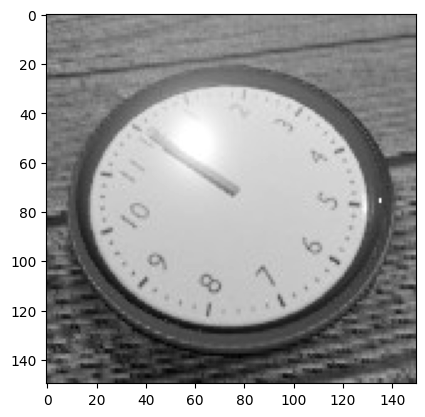

In [22]:
plt.imshow(data[0,:,:]/255.0, cmap='gray')
plt.show()
# plt.imshow(data[-1,:,:], cmap='gray')
# plt.show()
# plt.imshow(data[5000,:,:], cmap='gray')
# plt.show()

# Define the functions to make a network

In [7]:
def make_model(arch, optimizer,
               metrics: list = ["accuracy"],
               steps_per_execution: int = 1,
               summary_model: bool = False,
               loss_function = 'sparse_categorical_crossentropy'):

  # Create a dictionary of possible layers. In this case we can create any arbitary network
  # without having to constantly copy and paste lines.
  layer_dict = {
        "dense": Dense,             # units, activation=None
        "dropout": Dropout,         # rate, noise_shape=None, seed=None
        "conv": Conv2D,             # filters, kernel_size, strides=(1, 1), padding="valid", activation=None
        "maxpooling": MaxPooling2D, # pool_size=(2, 2), strides=None, padding="valid"
        "flatten": Flatten,
        "BN": BatchNormalization,
  }

  ##########################################

  # Initiate model
  model = keras.models.Sequential()

  ## Add input layer
  model.add(Input(shape=arch['input_shape']))

  ## Add layers
  for layer, kwargs in arch['layers']:
    # Use our dictionary to obtain the callable layer and put in the keywords arguments
    model.add(layer_dict[layer](**kwargs))

  # Output layer
  model.add(layer_dict[arch['output'][0]](**arch['output'][1]))

  ##########################################

  # Print summary if wanted
  if summary_model:
    model.summary()

  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=metrics,
                steps_per_execution=steps_per_execution)

  # Return model before fitting
  return model


def fit_model(model, X_train, y_train, scaling,
              epochs: int = 30, validation_split: float = 0.1,
              batch: int = 64, verbose: int = 0):

  history = model.fit(X_train/scaling, y_train, epochs=epochs,
                    validation_split = validation_split, batch_size=batch, verbose=verbose,
                    shuffle=True)

  return history


def eval_model(model, X_test, y_test, batch, verbose=1):
  return model.evaluate(X_test, y_test, batch_size=batch, verbose=verbose)


# Creating the architecture:

Given on Brightspace was the hint for having a number of parameters between 256 and 2048 for the last layer. Else the network would be too complex, leading to very long fitting times, as well as the possibility of having no convergence in a sufficient amount of time.

In [ ]:
classification_model_half_hours ={
    'input_shape':(150, 150, 1),
    # Output (we have in total 720 classes of time, 60*12, each with a given probability per item (returned by Softmax), but start by classes of 30 minutes)
    # Start with half hours
    'output': ('dense', {'units': 24, 'activation': 'softmax'}),

    'layers':[
        ('conv', {'filters': 9, 'kernel_size': 17, 'activation': 'relu'}),
        # An image has about 8 in height and 8 in width of freedom before having the clock in the image. So reduce the size using the kernel to have the clock in frame
        # Furthermore, 150/17 ~ 9, leaving 9 filters in total.
        ('maxpooling', {'pool_size': (2,2)}),

        # Now for the numbers on the clock. Say that a number is indicated in a size of about 15x15
        ('conv', {'filters': 12, 'kernel_size': 15, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),



        # Arrows on the clock. Given the 15x15 block we are in from the previous layer, make a kernel of 3x3
        # to seek the arrow indication. We need about 15*15/3*3 = 25 filters.
        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),




        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),

        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),

        ('flatten', {}),
        ('dense', {'units': 60, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 40, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
    ]
}
make_model(classification_model_half_hours, optimizer=keras.optimizers.Adam(),
          steps_per_execution=250, summary_model=True)

# display(keras.utils.plot_model(make_model(classification_model, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=False), show_layer_activations=True))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 9)       2610      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 9)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 12)        24312     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 12)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 25)        2725      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 25)       0

# Fit model:

In [ ]:
model_h = make_model(classification_model_half_hours, optimizer=keras.optimizers.Adam(),
          steps_per_execution=100, summary_model=False)


model_h.save('/content/model_h.keras')

In [ ]:
import os
# Get file size in bytes for a given model
os.stat('model_h.keras').st_size / 10**6

0.234091

In [ ]:
data.reshape(data.shape[0], *classification_model_half_hours['input_shape']).shape

(18000, 150, 150, 1)

In [ ]:
# Model for hours

# fit_model(mod, X_train_full.reshape(60000, 784), y_train_full, 255.0,
#                           verbose=1)

fitted_model1 = fit_model(model_h, data.reshape(data.shape[0], *classification_model_half_hours['input_shape']), labels_30min, 255.0, epochs=1,
                            verbose=1, batch=64*2, validation_split=0.2)

113/113 [==============================] - 291s 3s/step - loss: 3.1175 - accuracy: 0.0167 - val_loss: 4.0932 - val_accuracy: 0.0000e+00


In [ ]:
data.reshape(data.shape[0], *classification_model_half_hours['input_shape']).shape

(18000, 150, 150, 1)

In [ ]:
np.max(data)

255

In [ ]:
classification_model_half_hours['input_shape']

(150, 150, 1)

Test run with easy CNN

In [ ]:
test_model_arch ={
    'input_shape':(150, 150, 1),
    # Output (we have in total 720 classes of time, 60*12, each with a given probability per item (returned by Softmax), but start by classes of 30 minutes)
    # Start with half hours
    'output': ('dense', {'units': 24, 'activation': 'softmax'}),

    'layers':[
        ('conv', {'filters': 9, 'kernel_size': 17, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 5, 'kernel_size': 9, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 5, 'kernel_size': 9, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('flatten', {}),
        ('dense', {'units': 2048//2, 'activation': 'relu'}),
        ('dense', {'units': 512//2, 'activation': 'relu'}),
        ('dense', {'units': 256//2, 'activation': 'relu'}),
        ('dense', {'units': 128//2, 'activation': 'relu'}),
    ]
}

test_model = make_model(test_model_arch, optimizer=keras.optimizers.Adam(),
          steps_per_execution=512//2, summary_model=True)

fitted_model1 = fit_model(test_model, data.reshape(data.shape[0], *test_model_arch['input_shape']), labels_30min, 255.0, epochs=5,
                            verbose=1, batch=512, validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 134, 134, 9)       2610      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 67, 67, 9)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 59, 59, 5)         3650      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 29, 29, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 21, 21, 5)         2030      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 10, 10, 5)      

# 2A

# 2B

Make a regression model

In [3]:
# Round off each minute as 1/60 = 0.0166666..., use round 3 to make regression speed up (there is no point using all decimals)
labels_regression = labels[:, 0] + np.round(labels[:, 1]/60, 3)

In [44]:
len(np.unique(labels_regression))

720

In [4]:
# np.unique(labels_regression)

#### Histogram of labels:

(array([1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800.,
        1800.]),
 array([ 0.    ,  1.1983,  2.3966,  3.5949,  4.7932,  5.9915,  7.1898,
         8.3881,  9.5864, 10.7847, 11.983 ]),
 <BarContainer object of 10 artists>)

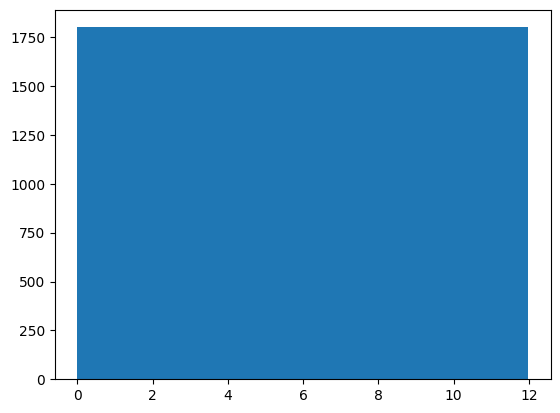

In [46]:
plt.hist(labels_regression)

### Create model

In [4]:
def regression_model(input_shape, default: bool = False):
        """
        Builds a regression model for floats of time.

        This model is composed of three Conv -> BN -> Pool -> Dropout blocks,
        followed by the Dense output layer.

        Last layer is a regression layer, output is only 1 value, activation function
        is linear.
        """
        inputs = Input(shape=input_shape)
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)

        if default:

          x = Dense(128)(x)
          x = Activation("relu")(x)
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(1)(x)
          x = Activation("linear", name="regression_output")(x)

        else:
          x = Dense(256)(x)
          x = Activation("relu")(x)
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(144)(x)
          x = Activation("relu")(x)
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(1)(x)
          x = Activation("linear", name="regression_output")(x)

        model = Model(inputs=inputs,
                     outputs = [x],
                  )
        return model


model_regression_default = regression_model(input_shape=(150,150, 1), default = True)
model_regression = regression_model(input_shape=(150,150, 1), default = False)


Display the model

In [18]:
# model_regression_default.summary()
# display(keras.utils.plot_model(model_regression_default, show_layer_activations=True))

In [13]:
# model_regression.summary()

Compile it: use a loss function of mean squared error (also try common sense error)

In [5]:
model_regression_default.compile(loss='mse', # we have equal distribution of data, so no outliers (no need for MAE as loss function)
              optimizer=keras.optimizers.Adam(learning_rate=0.0005,
                                              ), # Kwarg: 'decay' decreases the learning rate per epoch
              metrics=['mae', 'acc'],
              steps_per_execution=50,
              )

Split the train and test data - use 80%/20%

In [6]:
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
                                                      data, labels_regression, test_size=0.2, random_state=42
                                                                                                )

(array([1441., 1442., 1435., 1436., 1427., 1438., 1431., 1447., 1450.,
        1453.]),
 array([ 0.    ,  1.1983,  2.3966,  3.5949,  4.7932,  5.9915,  7.1898,
         8.3881,  9.5864, 10.7847, 11.983 ]),
 <BarContainer object of 10 artists>)

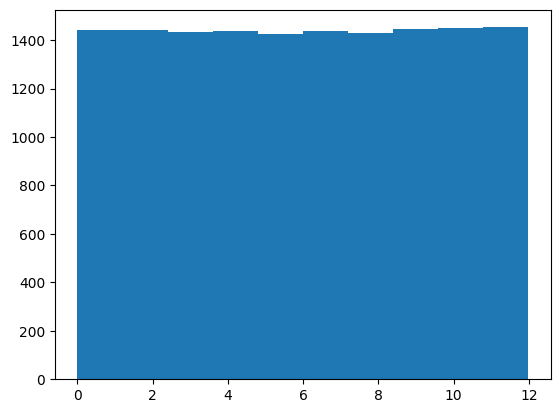

In [8]:
plt.hist(y_train_regression)

Fit the model

In [7]:
model_regression_default_with_shuffle = model_regression_default.fit(X_train_regression/255.0, y_train_regression,
                                                                      batch_size=32, validation_data=(X_test_regression/255.0, y_test_regression),
                                                                      epochs=50, shuffle=True)

Epoch 1/50
450/450 [==============================] - 37s 82ms/step - loss: 31.6280 - mae: 4.5982 - acc: 0.0017 - val_loss: 3620.7566 - val_mae: 57.5945 - val_acc: 8.3333e-04
Epoch 2/50
450/450 [==============================] - 37s 82ms/step - loss: 13.2185 - mae: 2.9615 - acc: 0.0015 - val_loss: 387.0799 - val_mae: 8.8942 - val_acc: 8.3333e-04
Epoch 3/50
450/450 [==============================] - 37s 81ms/step - loss: 11.6122 - mae: 2.7571 - acc: 0.0015 - val_loss: 245.4721 - val_mae: 8.7011 - val_acc: 0.0011
Epoch 4/50
450/450 [==============================] - 37s 81ms/step - loss: 10.5253 - mae: 2.6189 - acc: 0.0015 - val_loss: 564.1527 - val_mae: 17.5646 - val_acc: 0.0017
Epoch 5/50
450/450 [==============================] - 37s 81ms/step - loss: 9.8146 - mae: 2.5087 - acc: 0.0015 - val_loss: 10.1799 - val_mae: 2.5483 - val_acc: 8.3333e-04
Epoch 6/50
450/450 [==============================] - 36s 81ms/step - loss: 9.1823 - mae: 2.4192 - acc: 0.0015 - val_loss: 12.1735 - val_mae: 

Save the weights

In [9]:
model_regression_default.save_weights('/content/drive/MyDrive/IDL/A1/weights_model_regression_with_shuffle_2b.keras')

Visualize the performance

In [10]:
train_mae = model_regression_default_with_shuffle.history['mae']
test_mae = model_regression_default_with_shuffle.history['val_mae']



In [14]:
my_array = np.array(train_mae)
filename = 'train_mae_2b.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(test_mae)
filename = 'test_mae_2b.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

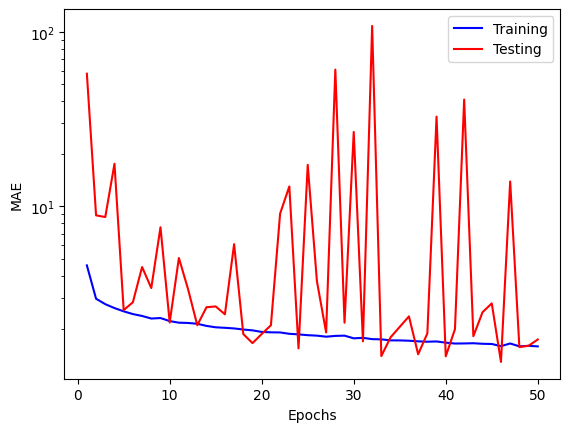

In [15]:
plt.plot(np.linspace(1, len(train_mae), len(train_mae)), train_mae, color='blue', label='Training')
plt.plot(np.linspace(1, len(train_mae), len(train_mae)), test_mae, color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.yscale('log')
plt.show()

Evaluate the model. Check if we are returned with a float between 0 and 11.9999....

In [22]:
y_pred = model_regression_default.predict(data/255.0)

563/563 [==============================] - 10s 18ms/step


In [24]:
residuals = labels_regression - y_pred.reshape(18000)

In [30]:
pd.DataFrame(residuals).describe()

,0
count,18000.000000
mean,-0.754591
std,2.000193
min,-33.304306
25%,-1.912417
50%,-0.725991
75%,0.408276
max,20.944242


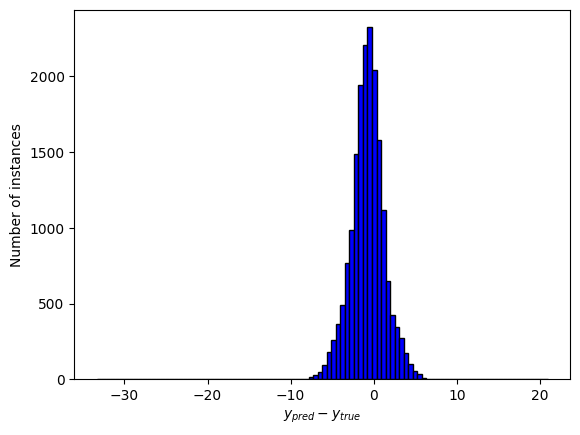

In [27]:
plt.hist(residuals, bins=100, edgecolor='black', color='blue')
plt.xlabel(r"$y_{pred} - y_{true}$")
plt.ylabel("Number of instances")
plt.show()

Try using a less complex architecture, i.e. the CNN of task 1.

In [7]:
model_CNN_fashion_MNIST = keras.models.Sequential([
                  keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                  input_shape=[150, 150, 1]),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
                  keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
                  keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.Flatten(),
                  keras.layers.Dense(128, activation="relu"),
                  keras.layers.Dropout(0.5),
                  keras.layers.Dense(64, activation="relu"),
                  keras.layers.Dropout(0.5),

                  # Change the final layer to linear in order to have regression
                  keras.layers.Dense(1, activation="linear")
                  ])

Compile, fit and plot results

In [8]:
model_CNN_fashion_MNIST.compile(loss='mse', # we have equal distribution of data, so no outliers (no need for MAE as loss function)
              optimizer=keras.optimizers.Adam(learning_rate=0.0005,
                                              ), # Kwarg: 'decay' decreases the learning rate per epoch
              metrics=['mae', 'acc'],
              steps_per_execution=50,
              )

model_CNN_fashion_MNIST.fit(X_train_regression/255.0, y_train_regression,
                            batch_size=32, validation_data=(X_test_regression/255.0, y_test_regression),
                            epochs=50, shuffle=True)

# Save weights
model_CNN_fashion_MNIST.save_weights('/content/drive/MyDrive/IDL/A1/model_CNN_fashion_MNIST_regression_2b.keras')


plt.plot(np.linspace(1, len(model_CNN_fashion_MNIST.history['mae']),
                     len(model_CNN_fashion_MNIST.history['mae'])),
         model_CNN_fashion_MNIST.history['mae'], color='blue', label='Training')
plt.plot(np.linspace(1, len(model_CNN_fashion_MNIST.history['val_mae']),
                     len(model_CNN_fashion_MNIST.history['val_mae'])),
         model_CNN_fashion_MNIST.history['val_mae'], color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.yscale('log')
plt.show()


# Predict
y_pred2 = model_CNN_fashion_MNIST.predict(data/255.0)
residuals2 = labels_regression - y_pred2.reshape(18000)

# Visualize
pd.DataFrame(residuals).describe()
plt.hist(residuals2, bins=100, edgecolor='black', color='blue')
plt.xlabel(r"$y_{pred} - y_{true}$")
plt.ylabel("Number of instances")
plt.show()

Epoch 1/50
450/450 [==============================] - 418s 930ms/step - loss: 16.3038 - mae: 3.3644 - acc: 0.0015 - val_loss: 12.3272 - val_mae: 3.0109 - val_acc: 8.3333e-04
Epoch 2/50
450/450 [==============================] - 412s 915ms/step - loss: 14.5806 - mae: 3.2171 - acc: 0.0015 - val_loss: 13.4257 - val_mae: 3.1034 - val_acc: 8.3333e-04
Epoch 3/50
450/450 [==============================] - 410s 911ms/step - loss: 14.3190 - mae: 3.1972 - acc: 0.0015 - val_loss: 11.8871 - val_mae: 2.9766 - val_acc: 8.3333e-04
Epoch 4/50
450/450 [==============================] - 411s 914ms/step - loss: 13.9809 - mae: 3.1764 - acc: 0.0015 - val_loss: 11.8225 - val_mae: 2.9720 - val_acc: 8.3333e-04
Epoch 5/50
450/450 [==============================] - 409s 909ms/step - loss: 13.7704 - mae: 3.1483 - acc: 0.0015 - val_loss: 11.9908 - val_mae: 2.9846 - val_acc: 8.3333e-04
Epoch 6/50
450/450 [==============================] - 409s 909ms/step - loss: 13.6512 - mae: 3.1406 - acc: 0.0015 - val_loss: 11.8

KeyboardInterrupt: ignored

# 2C

Idea: make 2 branches after the input, one branch for hours, one for minutes.

In [4]:
class MultiOutputModel():
    """
    Used to generate a multi-output model. This CNN contains two branches, one for hours, and the other for
    minutes. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:

        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x

    def build_minutes_branch(self, inputs, num_minutes=1):
        """
        Builds the minutes branch.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks,
        followed by the Dense output layer.

        Last layer is a regression layer, output is only 1 value, activation function
        is linear.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_minutes)(x)
        x = Activation("linear", name="minute_output")(x)
        return x

    def build_hour_branch(self, inputs, num_hours=12):
        """
        Builds the hour branch.

        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks,
        followed by the Dense output layer.

        Last layer is softmax, as we want to classify each clock's hour
        using a hour class
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(144)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(60)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(num_hours)(x)
        x = Activation("softmax", name="hour_output")(x)
        return x

    def assemble_full_model(self, input_shape, num_minutes, num_hours):
        """
        Used to assemble our multi-output model CNN.
        """
        inputs = Input(shape=input_shape)
        hour_branch = self.build_hour_branch(inputs, num_hours)
        minute_branch = self.build_minutes_branch(inputs, num_minutes)

        model = Model(inputs=inputs,
                     outputs = [hour_branch, minute_branch],
                  )

        return model

model = MultiOutputModel().assemble_full_model(input_shape=(150, 150, 1), num_hours=12, num_minutes=1)


In [27]:
# model.summary()

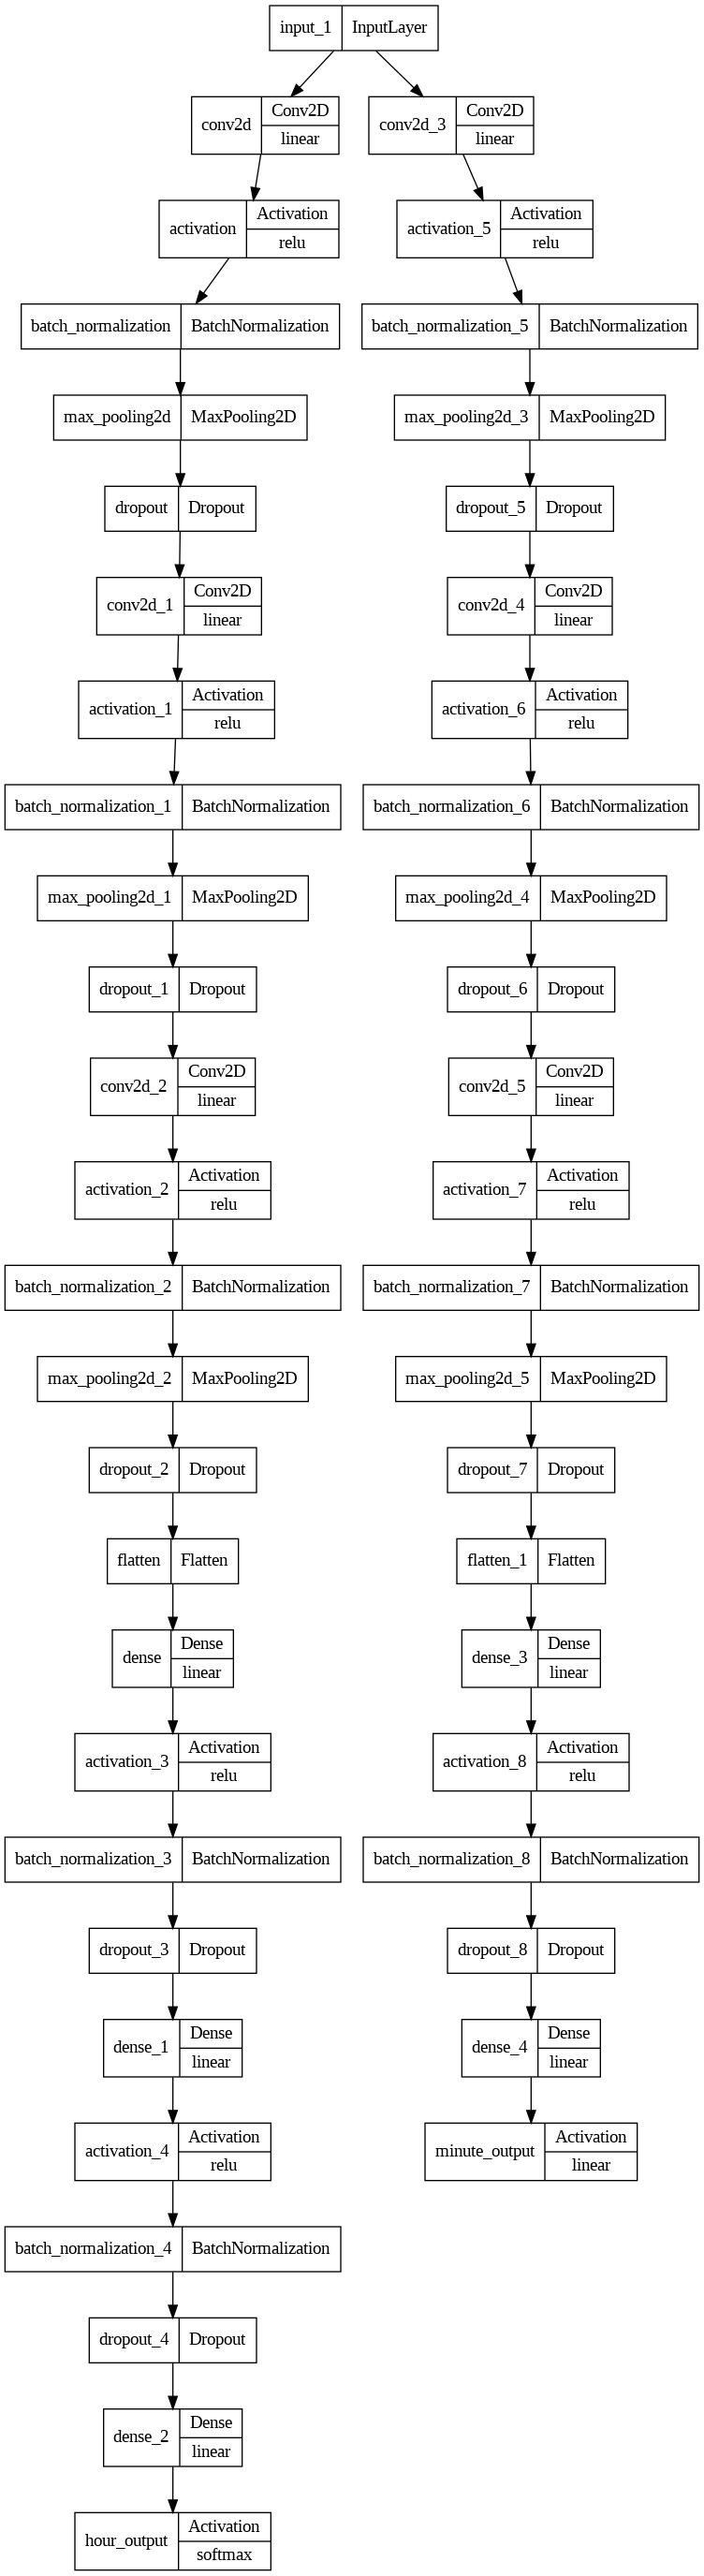

In [5]:
# model.summary()
display(keras.utils.plot_model(model, show_layer_activations=True))

#### Compile the model

Use sparse categorical cross entropy for the hour class, since we have a classification problem. Furthermore, for the regression problem, use the mean squared error. As optimizer use Adam, it is a fine working optimizer, and has a high accuracy for task 1, which also included images. In addition, use the accuracy and mean absolute error. Utilize our TPU by setting the steps per execution to 50.

In [5]:
model.compile(loss={'hour_output': 'sparse_categorical_crossentropy',
                    'minute_output': 'mse'},
              optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              metrics={'hour_output': 'accuracy',
                    'minute_output': 'mae'},
              steps_per_execution=50,
              )

#### It is 'time' to make 2 labelled classes, we have an hours class, this is the first column of our labeled set, labels[:, 0]. Our second labels are found for minutes. We divide by 60 to normalize these.

In [6]:
labels_h = labels[:,0]
labels_m = labels[:,1]


# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_m, y_test_m, y_train_h, y_test_h = train_test_split(
    data, labels_m, labels_h, test_size=0.2, random_state=42
)

Fit the model using two kinds of labels

In [6]:
model_with_shuffle = model.fit(X_train/255.0, [y_train_h, y_train_m], batch_size=32, validation_data=(X_test/255.0, [y_test_h, y_test_m]), epochs=30, shuffle=True)

Epoch 1/30
450/450 [==============================] - 48s 107ms/step - loss: 1019.7972 - hour_output_loss: 2.8614 - minute_output_loss: 1016.9355 - hour_output_accuracy: 0.0931 - minute_output_mae: 27.0689 - val_loss: 9526.0312 - val_hour_output_loss: 8.6912 - val_minute_output_loss: 9517.3379 - val_hour_output_accuracy: 0.0836 - val_minute_output_mae: 94.5192
Epoch 2/30
450/450 [==============================] - 38s 85ms/step - loss: 483.0362 - hour_output_loss: 2.5560 - minute_output_loss: 480.4800 - hour_output_accuracy: 0.1185 - minute_output_mae: 17.6991 - val_loss: 584.8771 - val_hour_output_loss: 2.4532 - val_minute_output_loss: 582.4240 - val_hour_output_accuracy: 0.1578 - val_minute_output_mae: 18.8350
Epoch 3/30
450/450 [==============================] - 38s 85ms/step - loss: 268.8876 - hour_output_loss: 2.3283 - minute_output_loss: 266.5591 - hour_output_accuracy: 0.1683 - minute_output_mae: 13.1294 - val_loss: 391.7095 - val_hour_output_loss: 2.8195 - val_minute_output_loss

In [11]:
# model.save_weights('/content/drive/MyDrive/IDL/A1/weights_model_with_shuffle_2c.keras')

Load our model and predict the values of hour and minutes for our training data. From this then calculate the common sense error. Make a histogram of this error. Then apply some statistics such as mean and standard deviation to have some further validation of the model.

In [9]:
model.load_weights('/content/drive/MyDrive/IDL/A1/weights_model_with_shuffle_2c.keras')

NameError: ignored

In [8]:
h_pred, m_pred = model.predict(X_test)

113/113 [==============================] - 4s 33ms/step


Without shuffle:

In [8]:
model.fit(X_train/255.0, [y_train_h, y_train_m], batch_size=32, validation_data=(X_test/255.0, [y_test_h, y_test_m]), epochs=30, shuffle=False)

Epoch 1/30
450/450 [==============================] - 57s 126ms/step - loss: 1023.8568 - hour_output_loss: 2.8757 - minute_output_loss: 1020.9808 - hour_output_accuracy: 0.0863 - minute_output_mae: 27.1263 - val_loss: 1610.5865 - val_hour_output_loss: 6.0335 - val_minute_output_loss: 1604.5526 - val_hour_output_accuracy: 0.0850 - val_minute_output_mae: 33.6580
Epoch 2/30
450/450 [==============================] - 47s 106ms/step - loss: 470.9027 - hour_output_loss: 2.6433 - minute_output_loss: 468.2593 - hour_output_accuracy: 0.0941 - minute_output_mae: 17.3959 - val_loss: 686.7924 - val_hour_output_loss: 2.7419 - val_minute_output_loss: 684.0505 - val_hour_output_accuracy: 0.0981 - val_minute_output_mae: 21.5268
Epoch 3/30
450/450 [==============================] - 48s 106ms/step - loss: 264.0695 - hour_output_loss: 2.5620 - minute_output_loss: 261.5074 - hour_output_accuracy: 0.1061 - minute_output_mae: 12.9509 - val_loss: 477.3272 - val_hour_output_loss: 2.9762 - val_minute_output_lo